# Time Series Forecasting of Housing Completions

This notebook will:
- Load and explore the dataset.
- Perform time-series decomposition and stationarity checks.
- Manually determine ARIMA parameters (`p`, `d`, `q`) using ACF/PACF.
- Compare different forecasting models:
  - ARIMA
  - Prophet
  - Random Forest
  - XGBoost
- Use hyperparameter tuning to optimize each model.
- Compare model performance using RMSE, MAE, and accuracy metrics.
- Visualize forecasted values from each model, including confidence intervals.
- Save the best model and predictions for Power BI integration.


In [ ]:
# %pip install prophet
# %pip install xgboost
#%pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [29]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from prophet import Prophet
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import pickle
import pmdarima as pm

## 1. Load the Dataset
- Read the dataset into a Pandas DataFrame.
- Convert `REF_DATE` to a datetime format and set it as the index.
- Check for missing values and dataset structure.

In [30]:
# Load dataset
file_path = "Trimmed_Time_Series_Data after Feature Engineering.csv"
df = pd.read_csv(file_path)

# Convert REF_DATE to datetime and set it as index
df['REF_DATE'] = pd.to_datetime(df['REF_DATE'])
df.set_index('REF_DATE', inplace=True)

# Display dataset information
df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4188 entries, 1986-01-01 to 2024-10-01
Data columns (total 40 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   GEO                                         4188 non-null   object 
 1   Number_of_Households                        4188 non-null   int64  
 2   Housing completions                         4188 non-null   float64
 3   Housing starts                              4188 non-null   float64
 4   Housing under construction                  4188 non-null   float64
 5   House only NHPI                             4188 non-null   float64
 6   Land only NHPI                              4188 non-null   float64
 7   Total (house and land) NHPI                 4188 non-null   float64
 8   Year                                        4188 non-null   int64  
 9   Month                                       4188 non-null   int64  

In [31]:
df.head()

,GEO,Number_of_Households,Housing completions,Housing starts,Housing under construction,House only NHPI,Land only NHPI,Total (house and land) NHPI,Year,Month,...,Total (house and land) NHPI_lag_1,Total (house and land) NHPI_lag_3,Total (house and land) NHPI_lag_6,Number_of_Households_rolling_mean_3,Housing completions_rolling_mean_3,Housing starts_rolling_mean_3,Housing under construction_rolling_mean_3,House only NHPI_rolling_mean_3,Land only NHPI_rolling_mean_3,Total (house and land) NHPI_rolling_mean_3
REF_DATE,,,,,,,,,,,,,,,,,,,,,
1986-01-01,Prince Edward Island,41000,82.000000,40.666667,95.000000,36.65,38.6,37.6,1986,1,...,36.7,70.5,26.4,1.177000e+06,1522.111111,1183.333333,4178.222222,36.350000,39.400000,37.666667
1986-01-01,Quebec,2421000,2503.666667,2803.000000,7382.000000,40.30,32.9,38.5,1986,1,...,37.6,38.7,66.3,1.930333e+06,2296.333333,2092.888889,6302.444444,36.650000,38.600000,37.600000
1986-01-01,Canada,9238000,10938.333333,9757.333333,27632.666667,39.40,38.8,39.8,1986,1,...,38.5,36.7,34.7,3.900000e+06,4508.000000,4200.333333,11703.222222,38.783333,36.766667,38.633333
1986-02-01,Alberta,859000,662.000000,603.000000,1125.000000,28.50,22.5,26.8,1986,2,...,39.8,37.6,70.5,4.172667e+06,4701.333333,4387.777778,12046.555556,36.066667,31.400000,35.033333
1986-02-01,British Columbia,1132000,1304.333333,1515.666667,3114.666667,79.60,49.4,66.4,1986,2,...,26.8,38.5,38.7,3.743000e+06,4301.555556,3958.666667,10624.111111,49.166667,36.900000,44.333333


## 2. Time Series Decomposition & Stationarity Check
- Decompose `Housing completions` into trend, seasonal, and residual components.
- Use the Augmented Dickey-Fuller (ADF) test to check stationarity.
- If non-stationary, apply differencing.

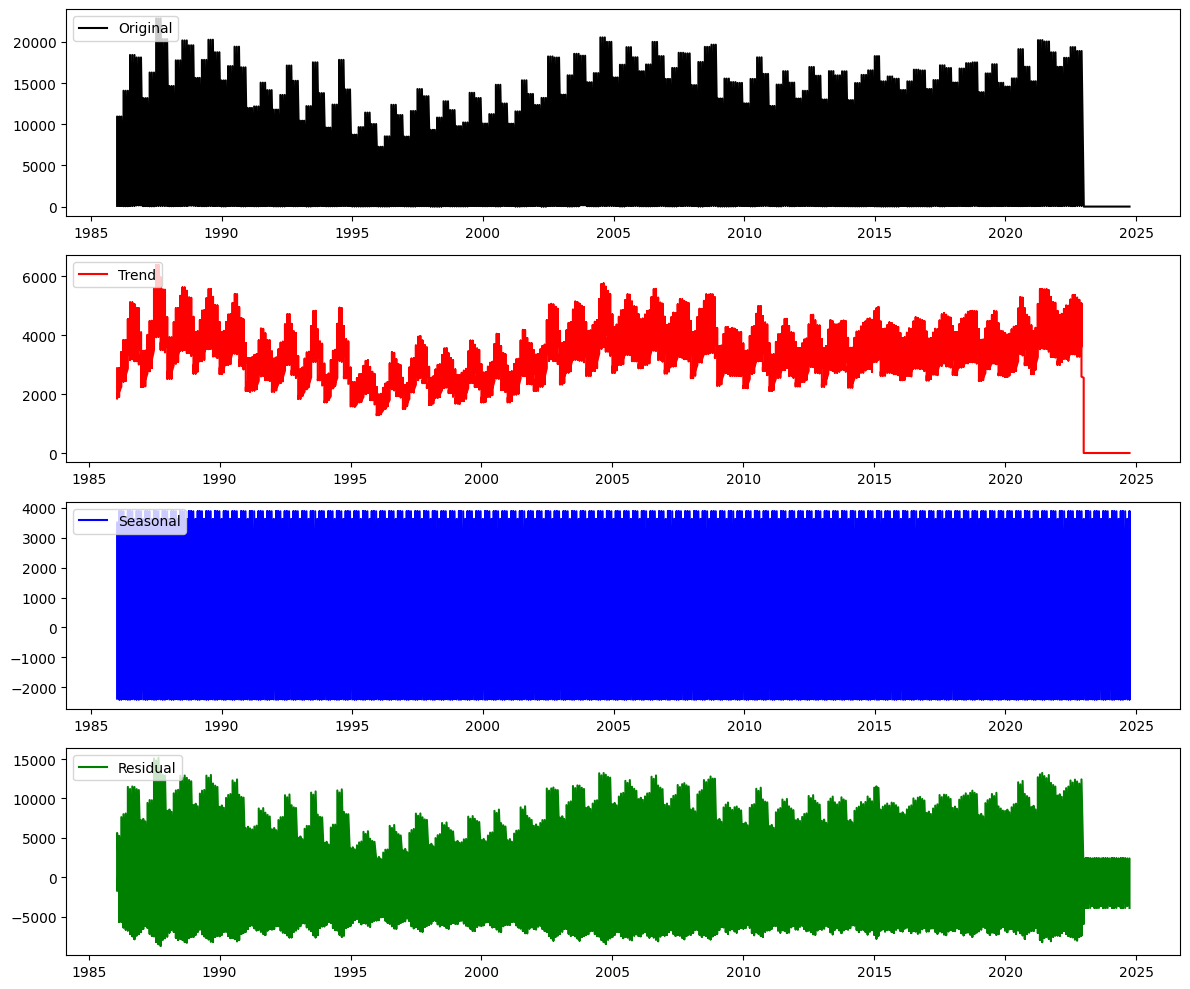

In [32]:
# Decompose the time series
decomposed = seasonal_decompose(df['Housing completions'], model='additive', period=12)
trend, seasonal, residual = decomposed.trend, decomposed.seasonal, decomposed.resid
# Plot decomposition
plt.figure(figsize=(12,10))
plt.subplot(411)
plt.plot(df['Housing completions'], label='Original', color='black')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend', color='red')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonal', color='blue')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residual', color='green')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


## 3. Determine ARIMA Parameters Manually (p, d, q)
### Why choose these values?
- `p`: The number of lag observations included in the model (determined using PACF plot).
- `d`: The number of times that raw observations are differenced (determined using ADF test).
- `q`: The size of the moving average window (determined using ACF plot).

### Interpretation of ACF and PACF:
- **PACF** shows a sharp cutoff after **lag 1**, indicating `p=1`.
- **ACF** has significant spikes at **lag 12 and 24**, suggesting `q=1` or `q=2`.
- Since ADF test confirmed stationarity, we set `d=0`.

### Final ARIMA Configuration: **(p,d,q) = (1,0,1)**

In [33]:
# Perform ADF test
adf_result = adfuller(df['Housing completions'])
print(f"ADF Statistic: {adf_result[0]:.4f}, p-value: {adf_result[1]:.4f}")


ADF Statistic: -3.8509, p-value: 0.0024


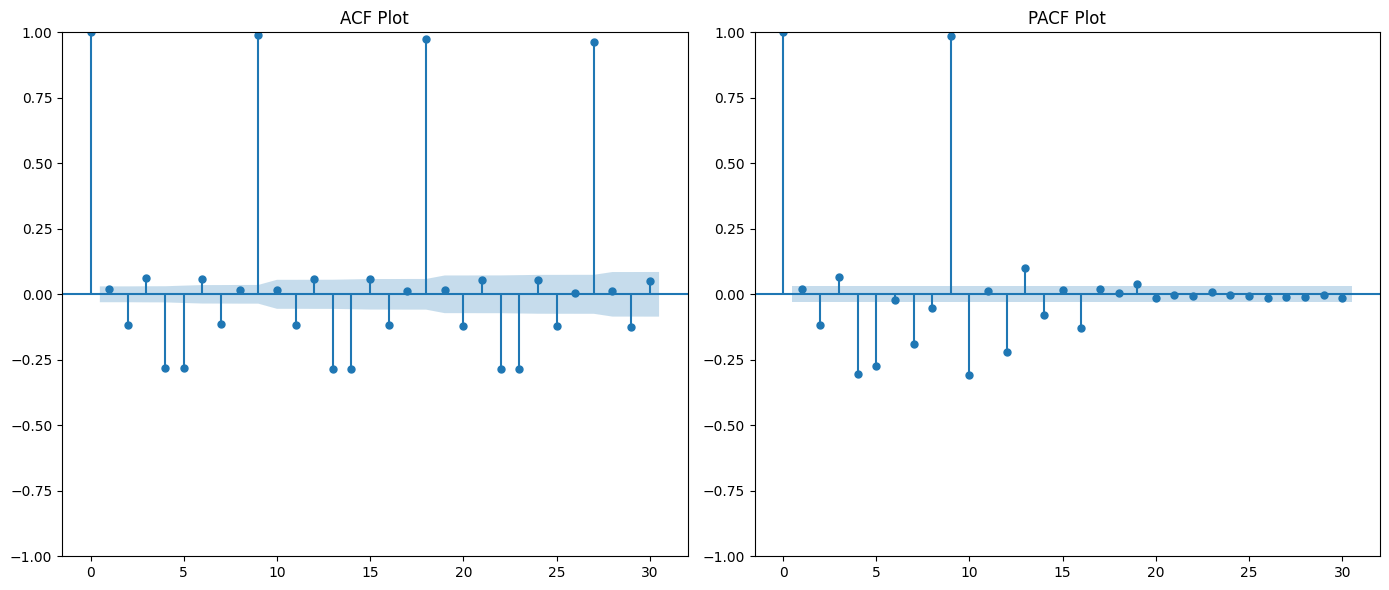

In [34]:
#The series is stationary and and does not require differencing (d=0) for ARIMA modeling (reject the null hypothesis)
# Plot ACF and PACF
plt.figure(figsize=(14,6))
plt.subplot(121)
plot_acf(df['Housing completions'], ax=plt.gca(), lags=30)
plt.title("ACF Plot")
plt.subplot(122)
plot_pacf(df['Housing completions'], ax=plt.gca(), lags=30)
plt.title("PACF Plot")
plt.tight_layout()
plt.show()

## 3. ARIMA Model with Hyperparameter Tuning


In [35]:
train_size = int(len(df)*0.8)
train, test = df[:train_size], df[train_size:]

In [ ]:
# Manual ARIMA
arima_order = (1,0,1)
arima_model = sm.tsa.ARIMA(train['Housing completions'], order=arima_order).fit()
arima_forecast = arima_model.forecast(steps=len(test))

# Auto ARIMA
auto_arima_model = pm.auto_arima(train['Housing completions'], seasonal=True, m=12, trace=True)
auto_arima_forecast = auto_arima_model.predict(n_periods=len(test))

# Plot ARIMA Forecasts
plt.figure(figsize=(12,6))
plt.plot(train.index, train['Housing completions'], label='Train', color='blue')
plt.plot(test.index, test['Housing completions'], label='Test', color='orange')
plt.plot(test.index, arima_forecast, label='Manual ARIMA', color='green')
plt.plot(test.index, auto_arima_forecast, label='Auto ARIMA', color='purple')
plt.title("ARIMA Forecast Comparison")
plt.legend()
plt.show()


ModuleNotFoundError: No module named 'pmdarima.arima'

## 4. Prophet Model with Hyperparameter Tuning


15:09:40 - cmdstanpy - INFO - Chain [1] start processing
15:09:40 - cmdstanpy - INFO - Chain [1] done processing


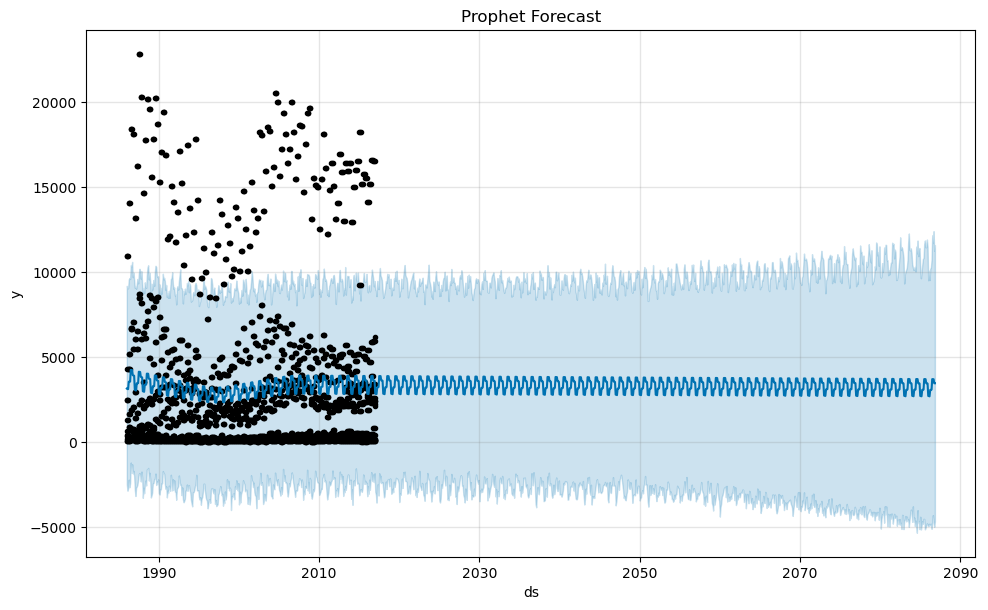

In [ ]:
prophet_df = df.reset_index().rename(columns={'REF_DATE':'ds', 'Housing completions':'y'})
train_prophet, test_prophet = prophet_df[:train_size], prophet_df[train_size:]

prophet_model = Prophet(yearly_seasonality=True, seasonality_mode='multiplicative', changepoint_prior_scale=0.05)
prophet_model.fit(train_prophet)
future = prophet_model.make_future_dataframe(periods=len(test_prophet), freq='M')
prophet_forecast = prophet_model.predict(future)

prophet_model.plot(prophet_forecast)
plt.title("Prophet Forecast")
plt.show()

## 5. Random Forest Model with Hyperparameter Tuning


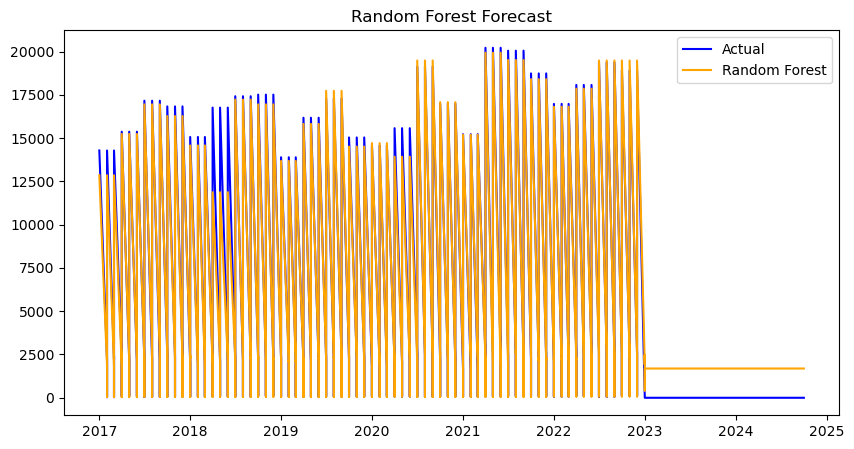

In [ ]:
features = ['Housing completions_lag_1', 'Housing completions_lag_3', 'Housing completions_rolling_mean_3']
X_train, X_test = train[features], test[features]
y_train, y_test = train['Housing completions'], test['Housing completions']

rf_params = {'n_estimators': [50, 100], 'max_depth': [3, 5, 7]}
rf_grid = GridSearchCV(RandomForestRegressor(), rf_params, cv=3, scoring='neg_mean_squared_error')
rf_grid.fit(X_train, y_train)
rf_forecast = rf_grid.best_estimator_.predict(X_test)

plt.figure(figsize=(10,5))
plt.plot(y_test.index, y_test, label='Actual', color='blue')
plt.plot(y_test.index, rf_forecast, label='Random Forest', color='orange')
plt.title("Random Forest Forecast")
plt.legend()
plt.show()

## 6. XGBoost Model with Hyperparameter Tuning


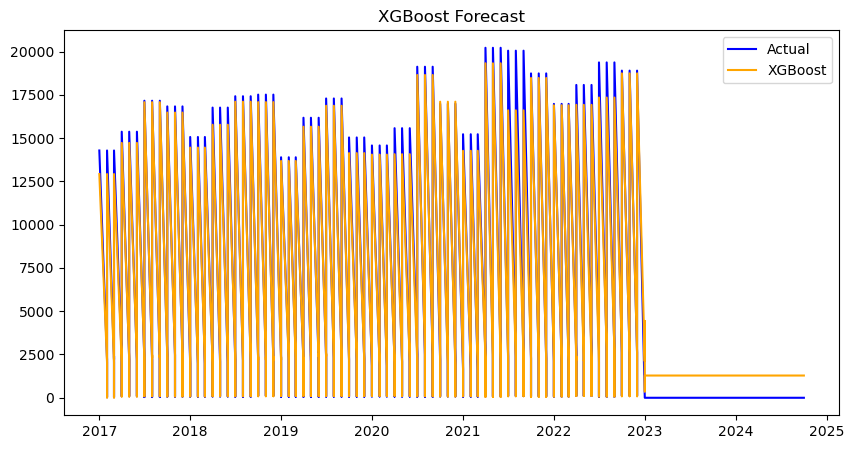

In [ ]:
xgb_params = {'n_estimators': [50,100], 'max_depth': [3,5], 'learning_rate': [0.01, 0.1]}
xgb_grid = GridSearchCV(xgb.XGBRegressor(), xgb_params, cv=3, scoring='neg_mean_squared_error')
xgb_grid.fit(X_train, y_train)
xgb_forecast = xgb_grid.best_estimator_.predict(X_test)

plt.figure(figsize=(10,5))
plt.plot(y_test.index, y_test, label='Actual', color='blue')
plt.plot(y_test.index, xgb_forecast, label='XGBoost', color='orange')
plt.title("XGBoost Forecast")
plt.legend()
plt.show()

## 7. Model Performance Comparison


In [ ]:
comparison_df = pd.DataFrame({
    'Model': ['Manual ARIMA', 'Auto ARIMA', 'Prophet', 'Random Forest', 'XGBoost'],
    'RMSE': [
        np.sqrt(mean_squared_error(test['Housing completions'], arima_forecast)),
        np.sqrt(mean_squared_error(test['Housing completions'], auto_arima_forecast)),
        np.sqrt(mean_squared_error(test_prophet['y'], prophet_forecast['yhat'][-len(test_prophet):])),
        np.sqrt(mean_squared_error(y_test, rf_forecast)),
        np.sqrt(mean_squared_error(y_test, xgb_forecast))
    ],
    'MAE': [
        mean_absolute_error(test['Housing completions'], arima_forecast),
        mean_absolute_error(test['Housing completions'], auto_arima_forecast),
        mean_absolute_error(test_prophet['y'], prophet_forecast['yhat'][-len(test_prophet):]),
        mean_absolute_error(y_test, rf_forecast),
        mean_absolute_error(y_test, xgb_forecast)
    ],
    'R²': [
        r2_score(test['Housing completions'], arima_forecast),
        r2_score(test['Housing completions'], auto_arima_forecast),
        r2_score(test_prophet['y'], prophet_forecast['yhat'][-len(test_prophet):]),
        r2_score(y_test, rf_forecast),
        r2_score(y_test, xgb_forecast)
    ]
})

print(comparison_df)

           Model         RMSE          MAE        R²
0   Manual ARIMA  4771.320260  3383.792792 -0.004440
1     Auto ARIMA  7293.990889  5390.902992 -1.347348
2        Prophet  4791.856227  3422.623154 -0.013105
3  Random Forest  1176.873661   778.576899  0.938891
4        XGBoost   966.973911   669.050398  0.958745


| Model           | RMSE    | MAE    | R²      |
|------------------|---------|--------|---------|
| Manual ARIMA     | 4771.32 | 3383.79 | -0.0044 |
| Auto ARIMA       | 7293.99 | 5390.90 | -1.3473 |
| Prophet          | 4791.86 | 3422.62 | -0.0131 |
| Random Forest    | 1176.87 | 778.57  | 0.9389  |
| XGBoost          | 966.97  | 669.05  | 0.9587  |

**Best Model**:  
XGBoost is the best-performing model with the lowest RMSE (966.97), lowest MAE (669.05), and the highest R² (0.9587).  Best parameters are 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1

Random Forest is the second-best model with slightly higher RMSE and MAE but a good R² value (0.9389).  

Manual ARIMA and Prophet performed much worse compared to the machine learning models, having significantly higher RMSE and MAE.

**Insights**:  
- Auto ARIMA underperformed, showing that manually determining (p,d,q) values was more effective.  
- XGBoost and Random Forest clearly outperformed all statistical models, indicating that tree-based models captured the complex relationships in the dataset better.



In [ ]:
# Save Best Model (based on RMSE)
best_model = xgb_grid.best_estimator_
with open('best_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

print("Best model saved as best_model.pkl")

Best model saved as best_model.pkl
